In [2]:
# %%
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import pandas as pd

In [3]:
# Set up Dask client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='8GB')
print(client)

/d/hpc/home/dp8949/.conda/envs/bd39/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33403 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45437' processes=16 threads=32, memory=119.21 GiB>


In [4]:
# Read data
data = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/dp8949/parquet_data/*.parquet')

In [5]:
# %%
# Create a summary of the data
summary = data.describe().compute()
print(summary)

       Summons Number  Violation Code  Street Code1  Street Code2  \
count    1.419870e+08    1.419870e+08  1.419870e+08  1.419870e+08   
mean     6.872420e+09    3.421889e+01  2.157168e+04  1.824402e+04   
std      2.300405e+09    1.875077e+01  2.256115e+04  2.158314e+04   
min      1.001716e+09    0.000000e+00  0.000000e+00  0.000000e+00   
25%      5.131114e+09    3.100000e+01  8.930000e+03  0.000000e+00   
50%      8.502029e+09    3.700000e+01  2.409000e+04  1.787000e+04   
75%      8.835496e+09    4.800000e+01  4.282000e+04  4.040400e+04   
max      9.120521e+09    9.900000e+01  9.829000e+04  9.831000e+04   

       Street Code3  Violation Location  Violation Precinct  Issuer Precinct  \
count  1.419870e+08        1.009822e+08        1.419870e+08     1.419870e+08   
mean   1.826563e+04        5.582528e+01        3.970336e+01     4.161555e+01   
std    2.171284e+04        3.853383e+01        4.118416e+01     6.130955e+01   
min    0.000000e+00        1.000000e+00       -1.000000e+0

In [6]:
# %%
# Print the percentage of missing values per column
print(f"{'column':<35}{'percentage of missing values':<20}")
missing_values = (data.isnull().sum() / len(data) * 100).compute()
for column, missing in missing_values.items():
    print(f'{column:<35} {missing:.2f}%')

column                             percentage of missing values
Summons Number                      0.00%
Plate ID                            0.01%
Registration State                  0.00%
Plate Type                          0.00%
Issue Date                          0.00%
Violation Code                      0.00%
Vehicle Body Type                   0.37%
Vehicle Make                        0.39%
Issuing Agency                      0.00%
Street Code1                        0.00%
Street Code2                        0.00%
Street Code3                        0.00%
Vehicle Expiration Date             6.77%
Violation Location                  28.88%
Violation Precinct                  0.00%
Issuer Precinct                     0.00%
Issuer Code                         0.00%
Issuer Command                      28.71%
Issuer Squad                        29.87%
Violation Time                      0.01%
Time First Observed                 93.40%
Violation County                    3.34%
Violatio

In [7]:
# %%
# Columns to keep
cols_to_keep =[
    'Registration State', 'Plate Type', 'Issue Date', 'Violation Time',
    'Violation Location', 'Violation Precinct', 'Issuer Precinct',
    'Issuer Code', 'Violation Code', 'Meter Number', 'Violation County',
    'Issuer Squad', 'Issuing Agency'
]
df = data[cols_to_keep]

In [8]:
# %%
# Summarize precinct location data
precinct_loc_df = df[['Violation Location', 'Violation Precinct', 'Issuer Precinct']]
print(precinct_loc_df.describe().compute().T)

                          count       mean        std  min   25%   50%    75%  \
Violation Location  100982213.0  55.825282  38.533830  1.0  33.0  70.0  114.0   
Violation Precinct  141986990.0  39.703360  41.184163 -1.0  10.0  46.0  103.0   
Issuer Precinct     141986990.0  41.615552  61.309547 -1.0   6.0  45.0  103.0   

                      max  
Violation Location  994.0  
Violation Precinct  994.0  
Issuer Precinct     999.0  


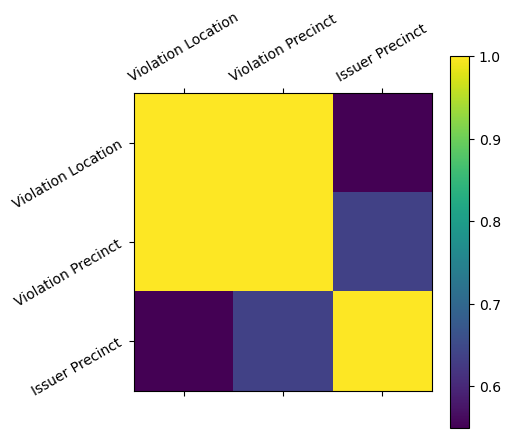

In [9]:
# %%
# Calculate the correlation matrix
corr = precinct_loc_df.corr().compute()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=30)
plt.yticks(range(len(corr.columns)), corr.columns, rotation=30)
plt.colorbar()
plt.show()

In [10]:
# %%
# Drop 'Violation Location' column
df = df.drop('Violation Location', axis=1)

In [11]:
# %%
# Print all columns and their data types
print(df.dtypes)

Registration State    string[pyarrow]
Plate Type            string[pyarrow]
Issue Date            string[pyarrow]
Violation Time        string[pyarrow]
Violation Precinct              int64
Issuer Precinct                 int64
Issuer Code                     int64
Violation Code                  int64
Meter Number          string[pyarrow]
Violation County      string[pyarrow]
Issuer Squad          string[pyarrow]
Issuing Agency        string[pyarrow]
dtype: object


In [12]:
# %%
# Combine 'Issue Date' and 'Violation Time' into a datetime column
df['Issue Date and Time'] = df['Issue Date'] + ' ' + df['Violation Time']
df['Issue Date and Time'] = df['Issue Date and Time'] + 'M'

# Use dd.to_datetime with format specified
df['Issue Date and Time'] = dd.to_datetime(df['Issue Date and Time'], format='%m/%d/%Y %I%M%p', errors='coerce')

In [14]:
# %%
# Print the head of the DataFrame
df.head()

,Registration State,Plate Type,Issue Date,Violation Time,Violation Precinct,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time
0,NY,PAS,12/18/1970,0358A,70,0,829379,20,-,K,0000,S,1970-12-18 03:58:00
1,NY,COM,02/02/1971,1116A,68,68,928157,46,-,K,0000,P,1971-02-02 11:16:00
2,NY,SRF,09/18/1971,0939A,104,0,515350,21,-,<NA>,0000,S,1971-09-18 09:39:00
3,TX,PAS,09/18/1971,0945A,104,0,515350,21,-,<NA>,0000,S,1971-09-18 09:45:00
4,NY,SRF,09/18/1971,0950A,104,0,515350,21,-,<NA>,0000,S,1971-09-18 09:50:00


In [15]:
# %%
# Remap 'Violation County' values
remap_county_dict = {
    'K' : 'Brooklyn', 'Q' : 'Queens', 'NY': 'Manhattan', 'QN': 'Queens', 
    'BK': 'Brooklyn', 'R' : 'Staten Island', 'BX': 'Bronx', 'ST': 'Staten Island', 
    'MN': 'Manhattan', 'KINGS': 'Brooklyn', 'QNS': 'Queens', 'BRONX': 'Bronx'
}
df['Violation County'] = df['Violation County'].map(remap_county_dict).astype('category')

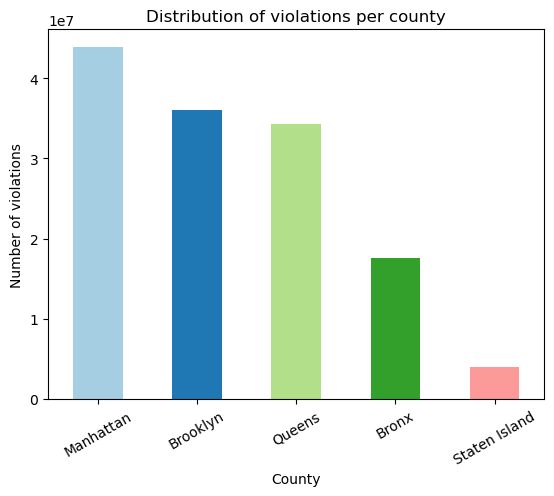

In [16]:
# %%
# Plot distribution of violations per county
violation_counts = df['Violation County'].value_counts().compute()
violation_counts.plot(kind='bar', color=plt.cm.Paired(range(len(violation_counts))))
plt.title('Distribution of violations per county')
plt.xlabel('County')
plt.ylabel('Number of violations')
plt.xticks(rotation=30)
plt.show()

In [17]:
# %%
# Extract month name for the violations
df['Month Name'] = df['Issue Date and Time'].dt.strftime('%B-%Y')

# Order the months correctly
ordered_months = [
    'July-2013', 'August-2013', 'September-2013', 'October-2013', 
    'November-2013', 'December-2013', 'January-2014', 'February-2014', 
    'March-2014', 'April-2014', 'May-2014', 'June-2014'
]

# Count violations per month and reindex to ensure the months are in the correct order
monthly_violations = df['Month Name'].value_counts().compute().reindex(ordered_months, fill_value=0)

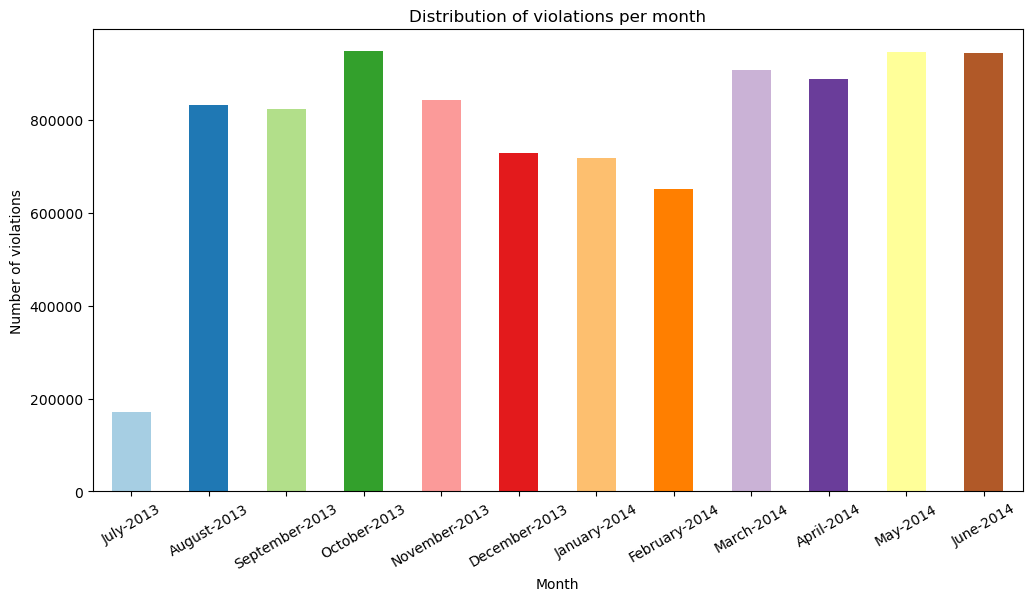

In [18]:
# %%
# Plot distribution of violations per month
plt.figure(figsize=(12, 6))
monthly_violations.plot(kind='bar', color=plt.cm.Paired(range(len(ordered_months))))
plt.title('Distribution of violations per month')
plt.xlabel('Month')
plt.xticks(rotation=30)
plt.ylabel('Number of violations')
plt.show()

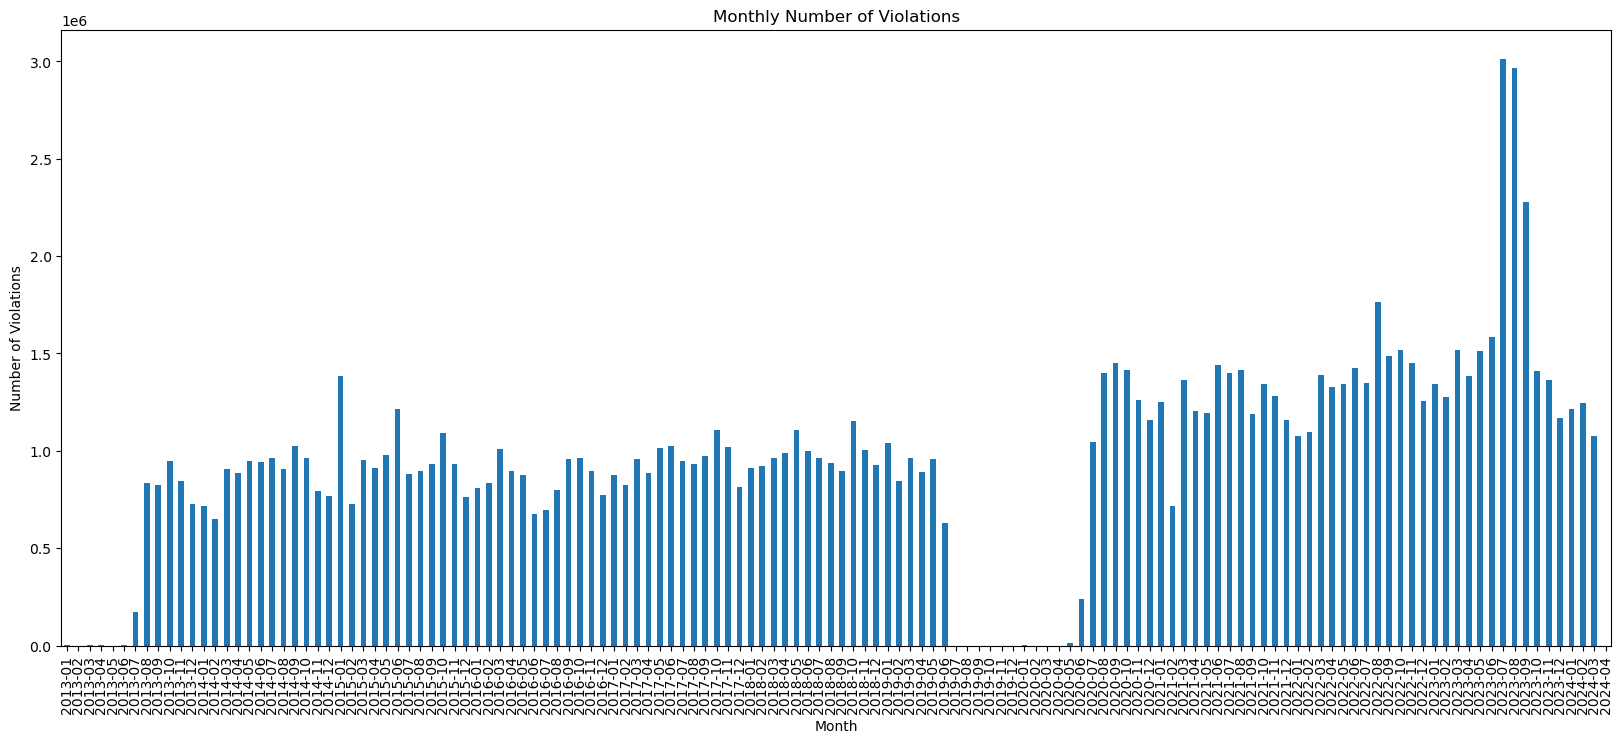

In [21]:
filtered_df = df[(df['Issue Date and Time'] >= '2013-01-01') & (df['Issue Date and Time'] < '2024-05-01')]

# Accumulate data for each month within the filtered date range
monthly_violations = filtered_df['Issue Date and Time'].dt.to_period('M').value_counts().compute().sort_index()

# Plot the accumulated monthly data
plt.figure(figsize=(20, 8))
monthly_violations.plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Number of Violations')
plt.title('Monthly Number of Violations')
plt.show()